In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
k1 = pd.read_csv('kick1.dat', sep=" ", header=None)
k2 = pd.read_csv('kick2.dat', sep=" ", header=None)
k1.columns =['x', 'y', 'z']
k2.columns =['x', 'y', 'z']

### <b>Exploratory Data Analysis</b>

In [3]:
print(k1.shape)
print(k2.shape)

(20, 3)
(20, 3)


In [4]:
k1.head()

,x,y,z
0,-0.210,2.048,0.145
1,-0.305,1.999,0.103
2,-0.368,1.968,0.149
3,-0.370,1.902,0.110
4,-0.480,1.841,0.135


In [5]:
k2.head()

,x,y,z
0,-0.105,2.048,0.145
1,-0.162,1.999,0.177
2,-0.184,1.968,0.172
3,-0.185,1.902,0.167
4,-0.230,1.841,0.192


In [6]:
k1.describe()

,x,y,z
count,20.000000,20.000000,20.000000
mean,-0.727700,1.576650,0.119600
std,0.294473,0.295319,0.014605
min,-1.192000,1.109000,0.103000
25%,-0.974000,1.328750,0.109500
50%,-0.742500,1.589500,0.114000
75%,-0.519000,1.815500,0.128250
max,-0.210000,2.048000,0.149000


In [7]:
k2.describe()

,x,y,z
count,20.000000,20.000000,20.000000
mean,-0.363200,1.576650,0.237800
std,0.146036,0.295319,0.047159
min,-0.596000,1.109000,0.145000
25%,-0.491500,1.328750,0.207750
50%,-0.361000,1.589500,0.247000
75%,-0.257000,1.815500,0.280250
max,-0.105000,2.048000,0.296000


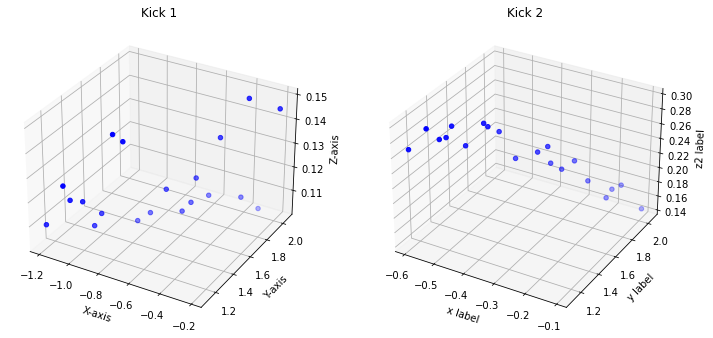

In [8]:
fig = plt.figure(figsize = (12, 12))

ax1 = fig.add_subplot(121,projection='3d')
#ax1.scatter(k1.iloc[:,0], k1.iloc[:,1], k1.iloc[:,2], c = 'b', marker='o')
ax1.scatter(k1['x'], k1['y'], k1['z'], c = 'b', marker='o')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('Z-axis')
plt.title("Kick 1")

ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter(k2['x'], k2['y'], k2['z'], c = 'b', marker='o')
ax2.set_xlabel('x label')
ax2.set_ylabel('y label')
ax2.set_zlabel('z2 label')
plt.title("Kick 2")

plt.show()

### <b>Linear Regression</b>

In [9]:
'''Construindo o tempo para 20 posições da bola no chute, dado que os dados são capturados a uma taxa de 
60 frames por segundo. Ou seja, cada posição da bola leva 0.016666667 segundos para ser capturado'''
i=0
T_full=[]
x=0.016666667
y=0
while i<=60:
    y=y+x
    T_full.append(y)
    i+=1
T=T_full[:20]
k1['t']=T
k2['t']=T

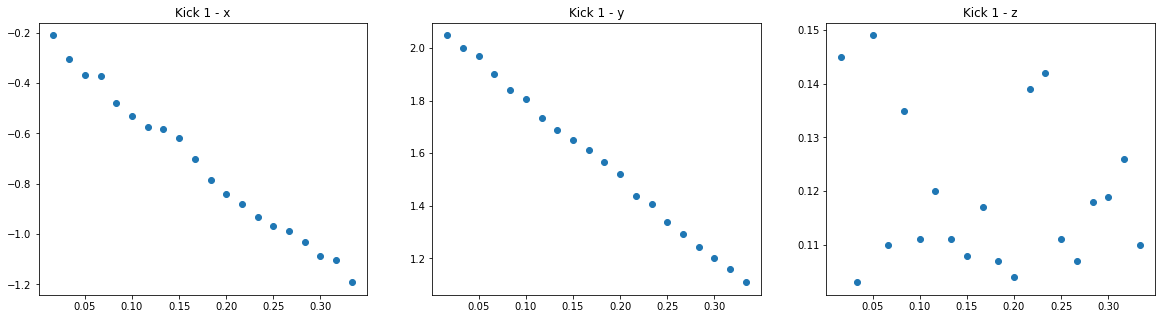

In [11]:
#resultados
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,5))
ax1.set(title="Kick 1 - x")
ax1.scatter(k1['t'],k1['x'])
ax2.set(title="Kick 1 - y")
ax2.scatter(k1['t'],k1['y'])
ax3.set(title="Kick 1 - z")
ax3.scatter(k1['t'],k1['z'])
plt.show()

In [12]:
def cost_function(y, y_hat):
    #MSE
    error = 0
    for i in range(len(k1)):
        error += (k1['x'][i] - y_hat[i]) ** 2

    return error / len(k1)

0
0.21860434448987212


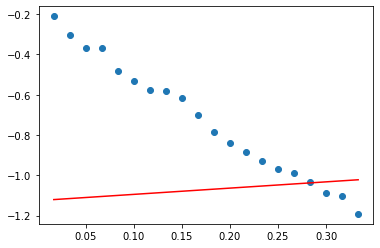

500
0.08699842978982512


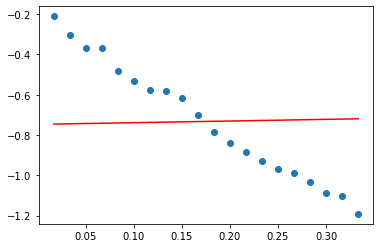

1000
0.07284295502874168


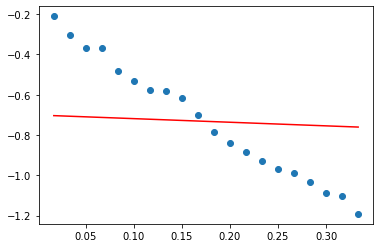

1500
0.06100985942588284


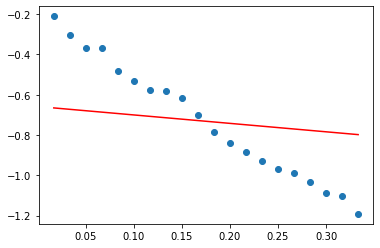

2000
0.05111812813989275


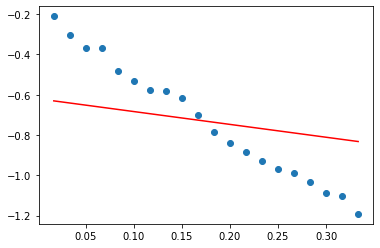

2500
0.042849256568315466


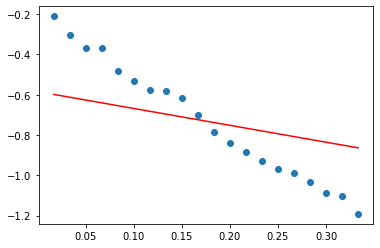

3000
0.03593699469115752


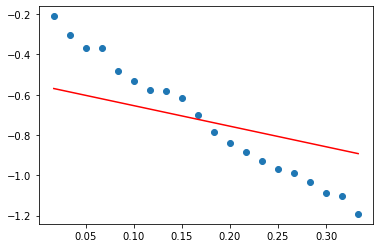

3500
0.03015877406639387


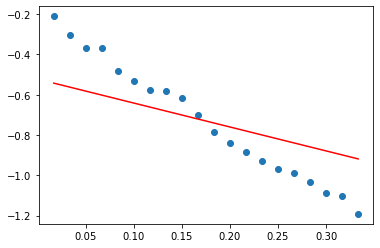

4000
0.025328541331899646


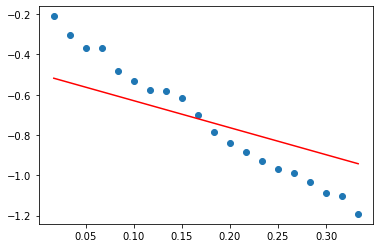

4500
0.021290767459197567


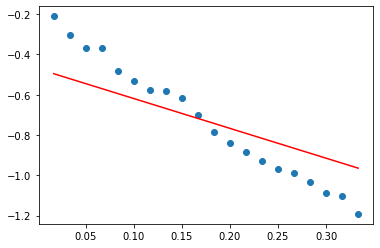

5000
0.017915439862527763


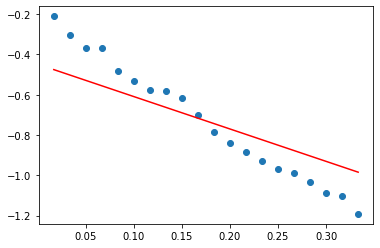

5500
0.015093876113784155


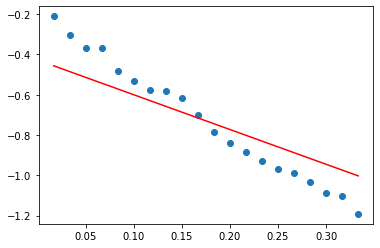

6000
0.012735224468806289


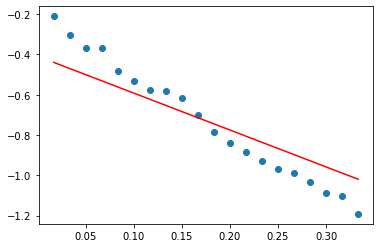

6500
0.010763538525210722


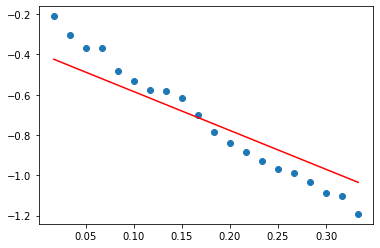

7000
0.0091153318184467


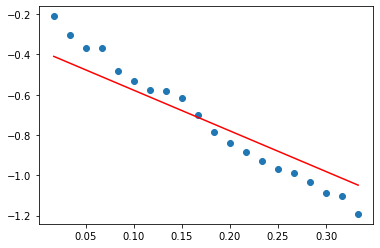

7500
0.007737533616331486


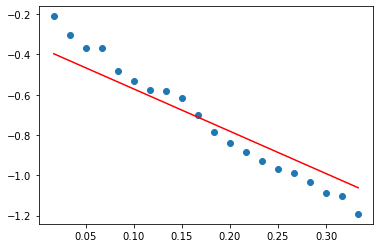

8000
0.006585780090538127


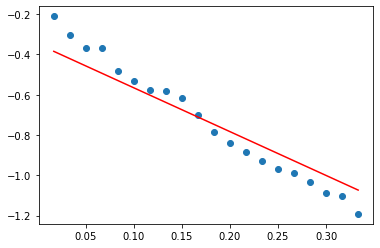

8500
0.005622985842337507


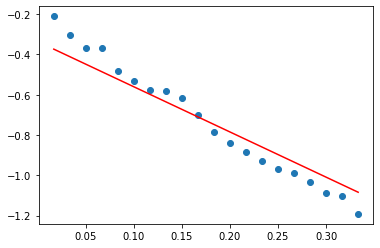

9000
0.004818149787045504


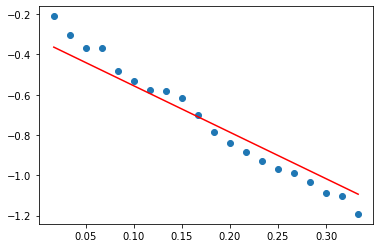

9500
0.004145356947756619


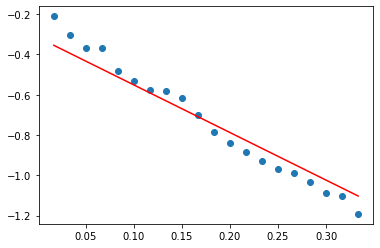

In [13]:
import random

loss = []
learning_rate = 0.01
n_iter = 10000
space_inter=n_iter/20

theta_0 = round(random.uniform(k1['x'].min(), k1['x'].max()),3)
theta_1 = round(random.uniform(k1['t'].min(), k1['t'].max()),3)


for i in range(n_iter):
    
    y_hat = theta_0 + np.dot(k1['t'],theta_1)
    
    mse = cost_function(k1['x'], y_hat)
    loss.append(mse)
    
    
    if i%space_inter==0:
        print(i)
        print(mse)
        plt.scatter(k1['t'],k1['x'])
        plt.plot(k1['t'],y_hat,c='red')
        plt.show()
    
    partial_w = (1 / len(k1)) * (2 * np.dot(np.array(k1['t']), (y_hat - k1['x'])))
    partial_d = (1 / len(k1)) * (2 * np.sum(y_hat - k1['x']))
    
    theta_1 -= learning_rate * partial_w
    theta_0 -= learning_rate * partial_d

### <b>Part 2</b>

In [51]:
from sklearn.datasets import load_digits
digits = load_digits()

In [57]:
X = digits.data
y = digits.target

In [53]:
print('X:',X.shape)
print('y:',y.shape)

X: (1797, 64)
y: (1797,)


In [58]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding.shape

(1797, 2)

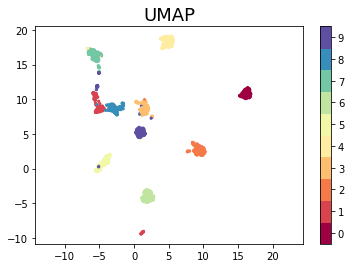

In [62]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP', fontsize=18);

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold